In [1]:
import os
import clr
import sys
from imp import reload
from System import Array
from time import sleep, time
import numpy as np
from matplotlib import pyplot as plt
# sys.path.append(os.getcwd())
%matplotlib inline

import qcodes as qc
qc.show_subprocess_widget()

<IPython.core.display.Javascript object>

# ATS

In [11]:
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_control
try:
    ATS.close()
    ATS_controller.close()
except:
    pass
reload(ATS_driver)
reload(ATS_control)

ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_control.Average_AcquisitionController(name='ATS_control', 
                                                           alazar_id=0,
                                                           server_name='Alazar_server')

ATS.config(trigger_source1='CHANNEL_C',
           trigger_level1=135,
           channel_range=2,
           sample_rate=1e6,
           coupling='DC')
ATS_controller.set_acquisitionkwargs(buffer_timeout=5000,
                                     samples_per_record=50000,
                                     records_per_buffer=1,
                                     buffers_per_acquisition=1,
                                     channel_selection='AC')

In [4]:
try:
    SIM900.close()
except:
    pass
import qcodes.instrument_drivers.stanford_research.SIM900 as SIM900_driver
reload(SIM900_driver)
SIM900 = SIM900_driver.SIM900('SIM900', 'GPIB0::4::INSTR')
TG, LB, RB, TGAC, SRC, _, DS, DF = [eval('SIM900.chan{}'.format(i)) for i in range(1,9)]


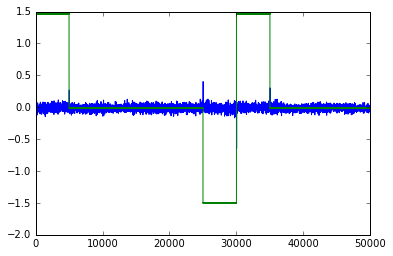

In [29]:
# ATS_controller.average_mode('point')
result = ATS_controller.do_acquisition()

plt.figure()
plt.plot(result[0])
plt.plot(result[1])

In [6]:
TGAC()

1.625

In [8]:
loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

data = qc.Loop(TGAC.sweep(1.62,1.625,0.001), delay=0.003).each(
    ATS_controller.acquire).run(name='testsweep')
plotQ = qc.QtPlot()
plotQ.add(data.ATS_control_acquire)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = 'data/2016-08-16/#005_testsweep_17-07-26'
   <Type>   | <array_id>          | <array.name> | <array.shape>
   Setpoint | SIM900_chan4_set    | chan4        | (6,)
   Measured | ATS_control_acquire | acquire      | (6,)
started at 2016-08-16 17:07:27


In [9]:
ATS_controller.acquire()

[array([-0.02539062, -0.02490234, -0.02416992, ..., -0.00146484,
        -0.01586914, -0.03588867]),
 array([-0.0222168 , -0.02075195, -0.02246094, ..., -0.015625  ,
        -0.01464844, -2.98291016])]

In [200]:
SIM900.close()